## **Predictive Maintenance using LSTM: Water Pump Systems**

* **Group 9:** Aktham Almomani
* **Course:** Data Analytics and Internet of Things (AAI-530-04)/ University Of San Diego
* **Semester:** Spring 2025

## **Contents**<a is='Contents'></a>
* [Introduction](#Introduction)
* [Dataset](#Dataset)
* [Setup and preliminaries](#Setup_and_preliminaries)
  * [Import Libraries](#Import_libraries)
  * [Helper functions](#Helper_Functions)
* [Importing the dataset](#Importing_the_dataset)
* [Preprocess the Data](#Preprocess_the_Data)
* [Create Time Series Sequences](#Create_Time_Series_Sequences)
* [Build and Train the LSTM Model](#LSTM)
  * [Evaluate the Model](#Evaluation)
  * [Visualizing Training Performance](#Visualizing)
  * [Visualizing Model Predictions vs. Actual Machine Status](#Visualizing_machine_status)
* [Saving the prediction dataset](#Saving_prediction)

## **Introduction**<a id='Introduction'></a>
[Contents](#Contents)

Predictive maintenance is crucial in industrial settings to prevent equipment failures and optimize maintenance schedules. In this notebook, we will use Long Short-Term Memory (LSTM), a specialized type of Recurrent Neural Network (RNN), to analyze sensor data and predict when the machine transitions from normal to abnormal.

**Steps in this Project:**
* Import Required Libraries
* Load and Explore the Dataset
* Preprocess the Data
* Create Time Series Sequences
* Build and Train the LSTM Model
* Evaluate the Model
* Make Predictions and Analyze Results

## **Dataset**<a id='Dataset'></a>
[Contents](#Contents)

The dataset we'll be using is called "Pump Sensor Data" and is available on [Kaggle](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data/data). This dataset provides real-world IoT sensor data collected from water pump systems.

**Data Collection**: The data was gathered from sensors installed in water pump systems. These sensors monitor a wide range of parameters such as motor and pump vibrations, frequencies, power usage, and bearing temperatures. The collection process spans over time, capturing changes in system behavior and helping identify operational issues or equipment failures.

**Dataset Overview**:
* Number of Observations: The dataset contains 220,320 entries.
* Number of Variables: There are 55 columns, including 52 numerical variables (sensor readings), one timestamp column, and one categorical column representing machine status

## **Setup and preliminaries**<a id='Setup_and_preliminaries'></a>
[Contents](#Contents)

### **Import libraries**<a id='Import_libraries'></a>
[Contents](#Contents)

In [1]:
# Data Handling & Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Machine Learning & Normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report

# Deep Learning - LSTM Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### **Helper functions**<a id='Helper_Functions'></a>
[Contents](#Contents)

In [2]:
def summarize_df(df):
    """
    Generate a summary DataFrame for an input DataFrame:
      - 'unique_count': No. unique values in each column.
      - 'data_types': Data types of each column.
      - 'missing_counts': No. of missing (NaN) values in each column.
      - 'missing_percentage': Percentage of missing values in each column.
    """
    # No. of unique values for each column:
    unique_counts = df.nunique()
    # Data types of each column:
    data_types = df.dtypes
    # No. of missing (NaN) values in each column:
    missing_counts = df.isnull().sum()
    # Percentage of missing values in each column:
    missing_percentage = 100 * df.isnull().mean()
    # Concatenate the above metrics:
    summary_df = pd.concat([unique_counts, data_types, missing_counts, missing_percentage], axis=1)
    # Rename the columns for better readibility:
    summary_df.columns = ['unique_count', 'data_types', 'missing_counts', 'missing_percentage']
    # Return summary df:
    return summary_df
#-----------------------------------------------------------------------------------------------------------------#
def value_counts_with_percentage(df, column_name):
    # Calculate value counts:
    counts = df[column_name].value_counts(dropna=False)

    # Calculate percentages:
    percentages = df[column_name].value_counts(dropna=False, normalize=True) * 100

    # Combine into a DataFrame and reset index:
    result = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages
    }).rename_axis(None).reset_index()

    # Rename the first column to match the original column name:
    result.rename(columns={'index': column_name}, inplace=True)

    return result
#-----------------------------------------------------------------------------------------------------------------#
def dynamic_impute(df, threshold=0.1):
    """
    Impute missing values dynamically based on the gap between mean and median.
    """
    # Get sensor columns:
    sensor_columns = [col for col in df.columns if col.startswith('snr')]

    for col in sensor_columns:
        mean_val = df[col].mean()
        median_val = df[col].median()

        # Calculate percentage difference:
        diff = abs(mean_val - median_val) / mean_val

        # Imputation decision:
        if diff <= threshold:
            # Mean and median are close, use the mean:
            df[col] = df[col].fillna(mean_val)
            print(f"Imputed '{col}' using mean (diff = {diff:.2%})")
        elif median_val > mean_val:
            # Median is significantly higher, use the median:
            df[col] = df[col].fillna(median_val)
            print(f"Imputed '{col}' using median because median > mean (diff = {diff:.2%})")
        else:
            # Use median for any other skewed cases:
            df[col] = df[col].fillna(median_val)
            print(f"Imputed '{col}' using median (diff = {diff:.2%})")

    return df


## **Importing the dataset**<a id='Importing_the_dataset'></a>
[Contents](#Contents)

Since I'm using google colab, let's mount the driver:

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv(
    '/content/drive/My Drive/Colab Notebooks/failure_cause_predictions.csv'
)

In [5]:
#now, let's look at the shape of df:
shape = df.shape
print("Number of rows:", shape[0], "\nNumber of columns:", shape[1])

Number of rows: 220320 
Number of columns: 30


In [6]:
# Here's, let's call again our helper function "summarize_df" to get more overall look about the columns in the dataset:
summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
timestamp,220320,object,0,0.000000
snr_01_motor_phase_current,187145,float64,0,0.000000
snr_02_motor_shaft_power,566,float64,0,0.000000
snr_03_motor_speed,7845,float64,0,0.000000
snr_04_pump_impeller_speed,100422,float64,0,0.000000
snr_05_pump_casing_vibration,152604,float64,0,0.000000
snr_06_pump_discharge_pressure,1109,float64,0,0.000000
snr_07_pump_lube_oil_supply_temp,910,float64,0,0.000000
snr_08_motor_casing_vibration,1254,float64,0,0.000000
snr_09_motor_phase_voltage,148001,float64,0,0.000000


In [7]:
df.head()

,timestamp,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage,...,failure_category,failure_cause,faulty_sensors,Predicted_Label,Prob_Class_0,Prob_Class_1,Prob_Class_2,Prob_Class_3,Prob_Class_4,Prob_Class_5
0,2018-04-01 00:00:00,31.11716,15.05353,634.3750,665.3993,2.565284,201.3889,31.51042,2.465394,466.3284,...,no_failure,no_failure,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-04-01 00:01:00,31.11716,15.05353,634.3750,665.3993,2.565284,201.3889,31.51042,2.465394,466.3284,...,no_failure,no_failure,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-04-01 00:02:00,32.08894,15.01013,638.8889,666.2234,2.500062,203.7037,31.25000,2.444734,459.6364,...,no_failure,no_failure,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-04-01 00:03:00,31.67221,15.08247,628.1250,666.0114,2.509521,203.1250,31.51042,2.460474,460.8858,...,no_failure,no_failure,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-04-01 00:04:00,31.95202,15.08247,636.4583,663.2111,2.604785,201.3889,31.51042,2.445718,468.2206,...,no_failure,no_failure,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## **Preprocess the Data**<a id='Preprocess_the_Data'></a>
[Contents](#Contents)

Preprocessing includes:

* Converting timestamps to datetime format.
* Sorting the dataset chronologically.
* Encoding the machine_status column into numerical values (0: Normal, 1: Abnormal).
* Normalizing sensor readings for better LSTM performance.

In [8]:
# First, let's convert timestamp column to datetime:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp")

# then let's encode machine status (0 for normal, 1 for abnormal):
df["machine_status_encoded"] = df["machine_status"].apply(lambda x: 1 if x != "ABNORMAL" else 0)

# Select relevant sensor columns:
sensor_columns = [
    "snr_01_motor_phase_current", "snr_02_motor_shaft_power", "snr_03_motor_speed",
    "snr_04_pump_impeller_speed", "snr_05_pump_casing_vibration", "snr_06_pump_discharge_pressure",
    "snr_07_pump_lube_oil_supply_temp", "snr_08_motor_casing_vibration", "snr_09_motor_phase_voltage"
]

# Normalize sensor data using MinMaxScaler:
scaler = MinMaxScaler()
df[sensor_columns] = scaler.fit_transform(df[sensor_columns])


In [9]:
# Check how many normal (0) and abnormal (1) statuses exist in the full dataset
print(df["machine_status_encoded"].value_counts())


machine_status_encoded
1    179916
0     40404
Name: count, dtype: int64


## **Create Time Series Sequences**<a id='Create_Time_Series_Sequences'></a>
[Contents](#Contents)

LSTM models work best with sequential data. We will:

* Define a time window (e.g., last 10 readings) as input.
* Use the corresponding future machine status as the target.

In [10]:
# First let's define time steps (history length for LSTM input):
time_steps = 10

# Then, let's define a function to create sequences:
def create_sequences(data, labels, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(labels[i + time_steps])
    return np.array(X), np.array(y)

#Now, let's use the optimal date range (included both Abnormal & Normal Machine status):
start_date = "2018-04-01"
end_date = "2018-05-30"

# Apply date filter:
df_filtered = df[(df["timestamp"] >= start_date) & (df["timestamp"] <= end_date)]

# time_steps:
X_filtered, y_filtered = create_sequences(
    df_filtered[sensor_columns].values, df_filtered["machine_status_encoded"].values, time_steps
)

# I had multiple passes t make sure both classes exist:
abnormal_indices = np.where(y_filtered == 1)[0]
normal_indices = np.where(y_filtered == 0)[0]

if len(abnormal_indices) == 0 or len(normal_indices) == 0:
    print("Error: One of the classes (0 or 1) is missing in the filtered data. Try expanding the date range.")
else:
    # Find the first occurrence of each class:
    first_abnormal_idx = abnormal_indices[0]
    first_normal_idx = normal_indices[0]

    # Ensure train-test split includes both classes:
    split_idx = max(int(0.8 * len(X_filtered)), first_abnormal_idx + 1, first_normal_idx + 1)

    # Split into training (80%) and testing (20%) sets:
    X_train, X_test = X_filtered[:split_idx], X_filtered[split_idx:]
    y_train, y_test = y_filtered[:split_idx], y_filtered[split_idx:]

    # Check class distribution:
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    unique_test, counts_test = np.unique(y_test, return_counts=True)

    print(f"Training Data Shape: {X_train.shape}, Training Labels Shape: {y_train.shape}")
    print(f"Testing Data Shape: {X_test.shape}, Testing Labels Shape: {y_test.shape}")
    print("Training Class Distribution:", dict(zip(unique_train, counts_train)))
    print("Testing Class Distribution:", dict(zip(unique_test, counts_test)))

Training Data Shape: (67960, 10, 9), Training Labels Shape: (67960,)
Testing Data Shape: (16991, 10, 9), Testing Labels Shape: (16991,)
Training Class Distribution: {0: 24619, 1: 43341}
Testing Class Distribution: {0: 2730, 1: 14261}


## **Build and Train the LSTM Model**<a id='LSTM'></a>
[Contents](#Contents)

We will now create an LSTM-based neural network with:

* Two LSTM layers to capture temporal dependencies.
* Dropout layers to prevent overfitting.
* Dense lyaers for Classification


In [11]:
# Define LSTM model:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, len(sensor_columns))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation="relu"),
    Dense(1, activation="sigmoid")  # Output layer (binary classification)
])

# Compile the model:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train the model:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.9505 - loss: 0.1382 - val_accuracy: 0.9943 - val_loss: 0.0195
Epoch 2/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9861 - loss: 0.0412 - val_accuracy: 0.9946 - val_loss: 0.0164
Epoch 3/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9867 - loss: 0.0369 - val_accuracy: 0.9954 - val_loss: 0.0155
Epoch 4/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.9890 - loss: 0.0330 - val_accuracy: 0.9954 - val_loss: 0.0140
Epoch 5/5
1062/1062 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.9899 - loss: 0.0305 - val_accuracy: 0.9968 - val_loss: 0.0311


### **Evaluate the Model**<a id='Evaluation'></a>
[Contents](#Contents)

After training, let's evaluate the performance using accuracy and classification metrics.

In [12]:
# Make predictions:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate model performance:
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Display classification report:
print(classification_report(y_test, y_pred))


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.9968
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2730
           1       1.00      1.00      1.00     14261

    accuracy                           1.00     16991
   macro avg       0.99      0.99      0.99     16991
weighted avg       1.00      1.00      1.00     16991



### **Visualizing Training Performance**<a id='Visualizing'></a>
[Contents](#Contents)

Now, let's plot the training and validation accuracy/loss to analyze the model's learning behavior.

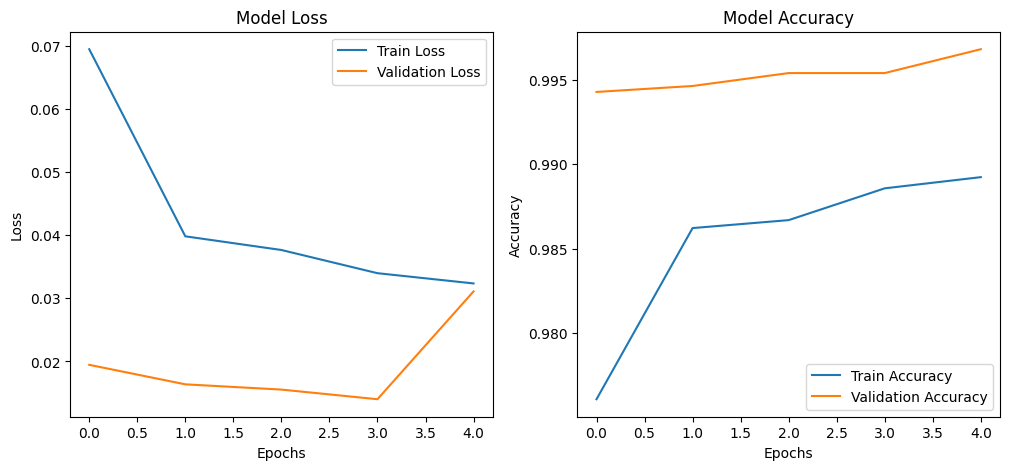

In [13]:
# Plot training history:
plt.figure(figsize=(12, 5))

# Loss plot:
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Model Loss")

# Accuracy plot:
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Model Accuracy")

plt.show()


**Summary Highlights:**

* Loss Trend: Train loss decreases consistently, but validation loss rises after epoch 3 "potential overfitting"
* Accuracy Trend: Both train and validation accuracy improve, with validation accuracy staying consistently high (~99.5%).


### **Visualizing Model Predictions vs. Actual Machine Status**<a id='Visualizing_machine_status'></a>
[Contents](#Contents)

Alright, now let's assess the performance of our LSTM model by visualizing the predicted machine status compared to the actual status over time. This helps identify correct predictions, transitions between normal and abnormal states, and misclassifications.

In [14]:
# Convert timestamps to match test set:
time_series_test = df["timestamp"].iloc[split_idx + time_steps:].values

# Convert predicted probabilities to binary labels:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)


531/531 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


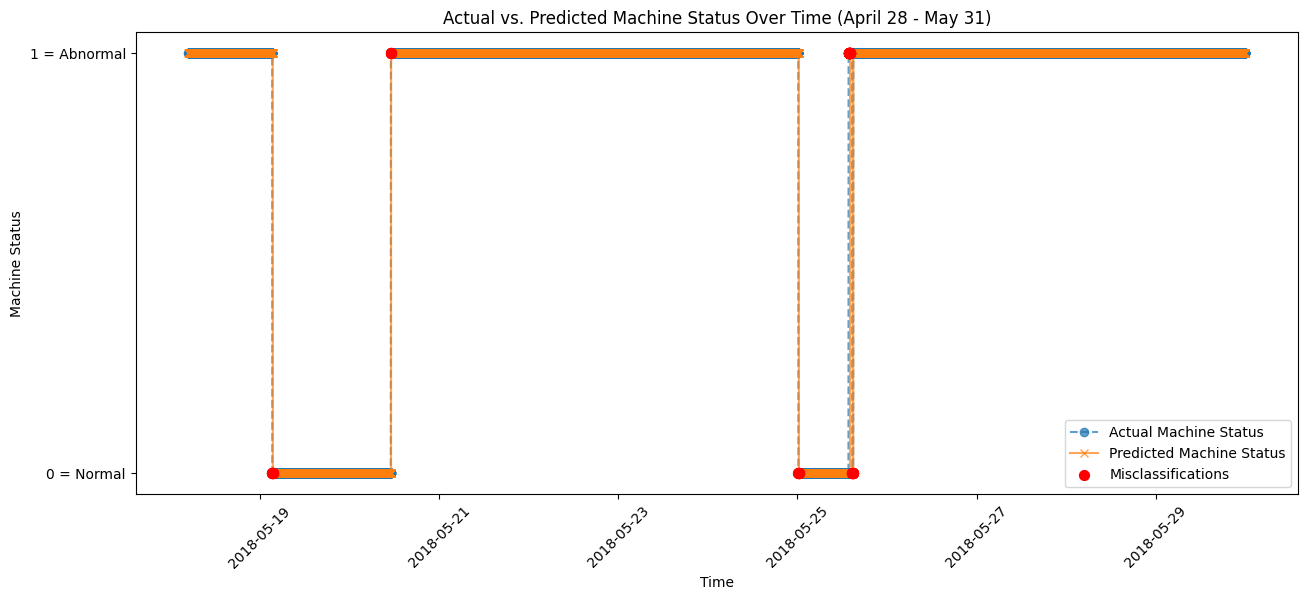

In [16]:
# Ensure predictions are 1D
y_pred = y_pred.flatten()
y_test = y_test.flatten()  # Ensure y_test is also 1D

# Get timestamps for the filtered time window (April 28 - May 31)
time_series_filtered = df_filtered["timestamp"].iloc[time_steps + split_idx:].values

plt.figure(figsize=(15, 6))

# Plot actual vs. predicted machine status
plt.plot(time_series_filtered, y_test, label="Actual Machine Status", linestyle="dashed", marker="o", alpha=0.7)
plt.plot(time_series_filtered, y_pred, label="Predicted Machine Status", linestyle="solid", marker="x", alpha=0.7)

# Highlight incorrect predictions
errors = np.abs(y_test - y_pred)  # Find mismatches (1 = incorrect)
plt.scatter(time_series_filtered[errors == 1], y_test[errors == 1], color='red', label="Misclassifications", zorder=3, s=50)

# Formatting
plt.xlabel("Time")
plt.ylabel("Machine Status")  # Adjusting label
plt.yticks([0, 1], labels=["0 = Normal", "1 = Abnormal"])  # Explicitly labeling y-axis
plt.title("Actual vs. Predicted Machine Status Over Time (April 28 - May 31)")
plt.legend()
plt.xticks(rotation=45)

plt.show()


**Summary Highlights:**

* Overall Alignment: Predicted machine status closely follows the actual machine status.
* Transitions Captured: Model correctly detects shifts between Normal (0) → Abnormal (1) and vice versa.
* Misclassifications (Red Dots): Some incorrect predictions occur at transition points.
* Potential Improvements: Fine-tuning our LSTM model or considering longer sequence windows to improve transition detection.

In [17]:
# Ensure predictions are 1D:
y_pred = y_pred.flatten()

# Create a new DataFrame for predictions:
df_predictions = df_filtered.iloc[time_steps + split_idx:].copy()
df_predictions["predicted_machine_status"] = y_pred

# Merge predictions back into the original df:
df = df.merge(df_predictions[["timestamp", "predicted_machine_status"]], on="timestamp", how="left")

# Display results:
df.head()

,timestamp,snr_01_motor_phase_current,snr_02_motor_shaft_power,snr_03_motor_speed,snr_04_pump_impeller_speed,snr_05_pump_casing_vibration,snr_06_pump_discharge_pressure,snr_07_pump_lube_oil_supply_temp,snr_08_motor_casing_vibration,snr_09_motor_phase_voltage,...,faulty_sensors,Predicted_Label,Prob_Class_0,Prob_Class_1,Prob_Class_2,Prob_Class_3,Prob_Class_4,Prob_Class_5,machine_status_encoded,predicted_machine_status
0,2018-04-01 00:00:00,0.691492,0.602141,0.792242,0.757067,0.526401,0.178571,0.023153,0.967194,0.777214,...,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
1,2018-04-01 00:01:00,0.691492,0.602141,0.792242,0.757067,0.526401,0.178571,0.023153,0.967194,0.777214,...,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
2,2018-04-01 00:02:00,0.713088,0.600405,0.797904,0.758004,0.513017,0.180952,0.022660,0.959089,0.766061,...,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
3,2018-04-01 00:03:00,0.703827,0.603299,0.784402,0.757763,0.514958,0.180357,0.023153,0.965264,0.768143,...,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN
4,2018-04-01 00:04:00,0.710045,0.603299,0.794855,0.754577,0.534507,0.178571,0.023153,0.959475,0.780368,...,no_faulty_sensors,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN


In [18]:
# Here's, let's call again our helper function "summarize_df" to get more overall look about the columns in the dataset:
summarize_df(df)

,unique_count,data_types,missing_counts,missing_percentage
timestamp,220320,datetime64[ns],0,0.000000
snr_01_motor_phase_current,187145,float64,0,0.000000
snr_02_motor_shaft_power,566,float64,0,0.000000
snr_03_motor_speed,7845,float64,0,0.000000
snr_04_pump_impeller_speed,100422,float64,0,0.000000
snr_05_pump_casing_vibration,152604,float64,0,0.000000
snr_06_pump_discharge_pressure,1109,float64,0,0.000000
snr_07_pump_lube_oil_supply_temp,910,float64,0,0.000000
snr_08_motor_casing_vibration,1254,float64,0,0.000000
snr_09_motor_phase_voltage,148001,float64,0,0.000000


## **Saving the prediction dataset**<a id='Saving_prediction'></a>
[Contents](#Contents)

In [19]:
# Alright, let's save the DataFrame as a CSV file:
df.to_csv('/content/drive/My Drive/Colab Notebooks/failure_cause_and_time_series_predictions.csv', index=False)